In [1]:
#### Load data ####

# Import the numpy library and fix random number seed for reproducibility
import numpy as np
import random
seed = 7
random.seed(seed)
np.random.seed(seed)

# Data consists of toy simulation hits and track parameters, stored in numpy arrays
# - 12 variables which are (phi, r, z) hit coordinates for each of the 4 stations 
#                in this order: phi_0, phi_1, phi_2, phi_3, r_1, r_2, r_3, r_4, z_1, z_2, z_3, z_4
# - 4 parameters which are signed 1/pT, cot(theta), phi at vertex, vertex z_0

try:
    data_loc = '/home/jlow/public/'
    the_variables = np.load(data_loc+'the_variables_emtf.npy')
    the_parameters = np.load(data_loc+'the_parameters_emtf.npy')
except:
    print "[ERROR] Cannot load the_variables_emtf.npy and/or the the_parameters_emtf.npy"

print "[INFO] Loaded the variables, shape: ", the_variables.shape
print "[INFO] Loaded the parameters, shape: ", the_parameters.shape

[INFO] Loaded the variables, shape:  (1000000, 12)
[INFO] Loaded the parameters, shape:  (1000000, 4)


In [2]:
#### Prepare data ####

# Pick variables and parameters
nvariables = 8   # only use the phi and r coordinates
nparameters = 1  # only use the signed 1/pT 

the_variables = the_variables[:, :nvariables]
the_parameters = the_parameters[:, :nparameters]
nentries = the_variables.shape[0]

# Split half and half into training and testing datasets
x_train = the_variables[:nentries/2, :]
y_train = the_parameters[:nentries/2]
x_test = the_variables[nentries/2:, :]
y_test = the_parameters[nentries/2:]

In [3]:
#### Import Keras library #####

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.regularizers import l2
from keras import initializers
from keras.optimizers import SGD

import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [4]:
#### Create a model ####

# See https://keras.io/models/about-keras-models/
#     https://keras.io/layers/about-keras-layers/
# for all kinds of things you can do with Keras

# Define model
# I define a simple model with 3 layers: layer 1 has 8 nodes; layer 2 has 4 nodes; 
# final layer is the output layer with 1 node
model = Sequential()
model.add(Dense(8, activation='tanh', kernel_initializer='normal', input_dim=8))
model.add(Dense(4, activation='tanh', kernel_initializer='normal'))
model.add(Dense(1, activation='linear'))

# Set loss and optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])

In [5]:
#### Training ####

#history = model.fit(x_train, y_train, epochs=400, validation_split=0.2, batch_size=1000, verbose=1)

# The webpage can become very unresponsive when you train with a large dataset with the above comment.
# So I do the following instead.
# See issue https://github.com/jupyter/notebook/issues/1474

import sys
old_stdout = sys.stdout
sys.stdout = open('keras_output.txt', 'w')
history = model.fit(x_train, y_train, epochs=400, validation_split=0.2, batch_size=1000, verbose=1)
sys.stdout.close()
sys.stdout = old_stdout

# Store model to file
model.save('model.h5')
model.save_weights('model_weights.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


453000/500000 [==========================>...] - ETA: 0s

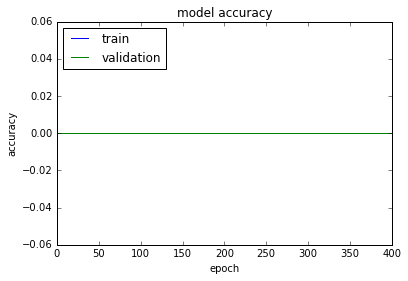

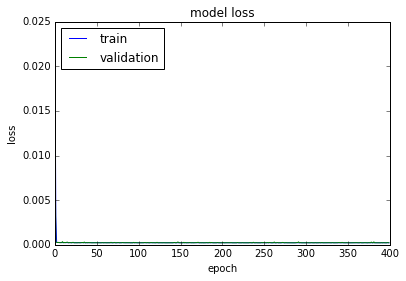

In [6]:
#### Evaluation using Keras internal tool ####

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=1000)

#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Welcome to JupyROOT 6.10/05


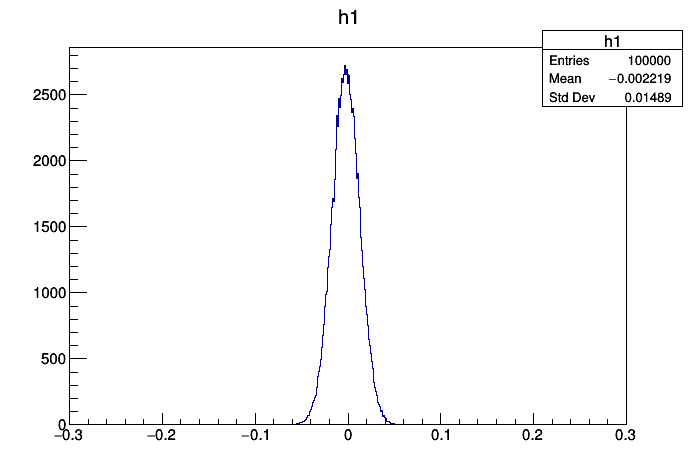

In [7]:
#### Evaluation by manually looping over the events ####

import ROOT

h1 = ROOT.TH1F("h1", "h1", 600, -0.3, 0.3)

#nentries_test = x_test.shape[0]
nentries_test = 100000

# Loop over events
for i in xrange(nentries_test):
    y = model.predict(np.array(x_test[i, :]).reshape(1,nvariables))
    y_true = y_test[i, 0]
    y_meas = y[0, 0]    
    h1.Fill(y_meas - y_true)

# Draw
c = ROOT.TCanvas()
h1.Draw()
c.Draw()